# PRO

In [114]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [115]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

In [116]:
def treinar_e_reportar(models, X_train, y_train, X_test, y_test):
    for model in models:
        print(model)
        if(model == xgb_model):
            y_train = enc.transform(y_train.array.reshape(-1, 1))
            y_test = enc.transform(y_test.array.reshape(-1, 1))
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        print('Acurácia teste: ', accuracy_score(y_test, preds)*100)
        print(classification_report(y_test, preds, digits=3))
        imprimeMatrizDeConfusão(y_test, preds, model)
        preds = model.predict(X_train)
        print('Acurácia treino: ', accuracy_score(y_train, preds)*100)
        print(classification_report(y_train, preds, digits=3))   

In [117]:
# Função para rodar GLM

def glm_treinar_e_reportar(df_train, df_test, method = 'bfgs'):
    from patsy import dmatrices
    import statsmodels.api as sm

    df_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl', 'Comportamento']]
    df_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl', 'Comportamento']]

    y_train, X_train = dmatrices( 'Comportamento ~ X + Y + Z + Season_fall + Season_spring + Season_summer + magn + sma + ent + pit + rol + icl', data=df_train, return_type='dataframe')

    y_test, X_test = dmatrices( 'Comportamento ~ X + Y + Z + Season_fall + Season_spring + Season_summer + magn + sma + ent + pit + rol + icl', data=df_test, return_type='dataframe')

    X_train, X_test = reescalar_dados(X_train, X_test)

    glm_model = sm.MNLogit(y_train, X_train) 

    glm_results = glm_model.fit(method=method)

    preds = glm_results.predict(X_test)

    preds[3] = preds.median(axis=1)

    preds = preds.reset_index(drop=True)

    b = np.zeros((preds.shape[0], 3))

    for i in range(preds.shape[0]):
        for j in range(3):
            if preds.loc[i,j] > preds.loc[i,3]:
                b[i,j] = 1
            else:
                b[i,j] = 0

    preds = pd.DataFrame(b, columns=['Ocio', 'Pastejando', 'Ruminando'])

    print('Acurácia teste: ', accuracy_score(y_test, preds)*100)

    print(classification_report(y_test, preds, digits=3))

    # Reverso de get_dummies
    preds = preds.idxmax(axis=1)

    y_test = y_test.rename(columns={"Comportamento[Ocio]" : "Ocio", "Comportamento[Pastejando]" : "Pastejando", "Comportamento[Ruminando]" : "Ruminando"})

    y_test = y_test.idxmax(axis=1)

    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    plt.show()

In [118]:
# Função do Bresolin

def metrics(curr_path, outdir, path_inference, cfgname, task, nclass, thr, proc):
    '''
    Get all metrics and save in text file
    '''    
    pred = pd.read_table(os.path.join(curr_path, outdir, path_inference, cfgname.replace('.cfg', '.pred')), header = None, sep = ' ').to_numpy()
    if task == 'class':
        y_obs = pred[:,0].astype(int)
        y_pred = (pred[:,1] > thr).astype('int')
        cm_mat = confusion_matrix(y_obs, y_pred)
       
        if cm_mat.shape[0] != cm_mat.shape[1]:
            sys.exit('Error: Number of true and predicted classes are different.\
                     Please contact the developer: tgbresolin@gmail.com!!!\n')
        elif cm_mat.shape[0] == 1:
            sys.exit('Error: Number of true classes are equal 1.\
                     Please contact the developer: tgbresolin@gmail.com!!!\n')
        elif cm_mat.shape[1] == 1:
            sys.exit('Error: Number of predicted classes are equal 1.\
                     Please contact the developer: tgbresolin@gmail.com!!!\n')  
        metrics = []
       
        if nclass == 2:
            tp = cm_mat[1,1]
            tn = cm_mat[0,0]
            fp = cm_mat[0,1]
            fn = cm_mat[1,0]
            acc = round(((tp + tn) / (tp + tn + fp + fn)), 2) * 100
            err = 100 - acc
            sen = round((tp / (tp + fn)), 2) * 100
            spe = round((tn / (tn + fp)), 2) * 100
            ppv = round((tp / (tp + fp)), 2) * 100
            npv = round((tn / (tn + fn)), 2) * 100
            metrics = pd.DataFrame(data = {'ACC': [acc], 'ERR': [err], 'SEN': [sen],
                                           'SPE': [spe], 'PPV': [ppv], 'NPV': [npv]})
        # else: for more than 2 two classes
    else:
        stats = np.load(os.path.join(curr_path, outdir, 'data/train/stats.npy'), mmap_mode = 'r')
        pred = backTransform(pred, stats, proc)
        x = pred[:,1]
        y = pred[:,0]
        mse = (1/ len(x)) * np.sum((y - x)**2)
        rmse = mt.sqrt(mse)
       
        x = x.reshape((-1, 1))
        model = LinearRegression().fit(x, y)
        r2 = model.score(x, y)
        slope = model.coef_[0]
        metrics = pd.DataFrame(data = {'R2': [r2], 'Slope': [slope], 'MSE': [mse], 'RMSE': [rmse]})
    metrics.to_csv(os.path.join(curr_path, outdir, path_inference, cfgname.replace('.cfg','.stat')), sep = ' ', header = True, mode = 'w', decimal = '.', index = False)

## Leave One Group Out

In [119]:
from sklearn.model_selection import LeaveOneGroupOut
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [120]:
# Modelos PRO
lgb_model = LGBMClassifier(learning_rate=0.1, num_leaves=512, min_child_samples=1, subsample=1.0, 
                           colsample_bytree=0.662, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1)

rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=None, 
                                  criterion='entropy', min_samples_split=10, min_samples_leaf=2 , bootstrap=True, random_state=0, n_jobs=-1)

knn_model = KNeighborsClassifier(n_neighbors=37, weights='distance', leaf_size=20, p=1, n_jobs=-1)

xgb_model = XGBClassifier(learning_rate=0.1, max_depth=16, min_child_weight=1, gamma=0.0, colsample_bytree=0.5370264280766771, use_label_encoder=False, random_state=0, n_jobs=-1)

rn_model = MLPClassifier(hidden_layer_sizes=(20,30,30,20), activation="tanh", learning_rate="adaptive", random_state=0)

models = [lgb_model, rf_model, knn_model, rn_model, xgb_model]

In [121]:
caminho_dados_lazaro = 'Datasets/Lazaro/dados_pre_processados_lazaro.csv'

In [122]:
df = pd.read_csv(caminho_dados_lazaro)

In [123]:
# Remove as linhas com o sensor 434138
df = df[df.SensorID != 434138]

In [124]:
df.columns

Index(['Piquete', 'Altura real', 'Altura esperada', 'Animal', 'SensorID',
       'Sensor Name', 'Date', 'X', 'Y', 'Z', 'Comportamento', 'Season_fall',
       'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol',
       'icl'],
      dtype='object')

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [125]:
y = df.Comportamento
X = df[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]

enc = OrdinalEncoder()
enc.fit(y.array.reshape(-1, 1))

OrdinalEncoder()

In [126]:
# Para reescalar os dados
def reescalar_dados(X_train, X_test):
    from sklearn.preprocessing import StandardScaler

    X_train_season = X_train[['Season_fall', 'Season_spring', 'Season_summer']]
    X_test_season =  X_test[['Season_fall', 'Season_spring', 'Season_summer']]

    X_train = X_train.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1)
    X_test = X_test.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1)

    columns = X_train.columns
    index_train = X_train.index
    index_test = X_test.index


    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform (X_test)

    X_train = pd.DataFrame(X_train, columns=columns, index=index_train)
    X_test = pd.DataFrame(X_test, columns=columns, index=index_test)

    X_train = pd.concat([X_train, X_train_season], axis=1)
    X_test = pd.concat([X_test, X_test_season], axis=1)
    
    return X_train, X_test

#### Leave Fall Out

In [127]:
df_test = df[df.Season_fall == 1]

In [128]:
df_train = df[df.Season_fall == 0]

In [129]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

LGBMClassifier(colsample_bytree=0.662, min_child_samples=1, num_leaves=512,
               random_state=0, subsample_freq=1)
Acurácia teste:  60.33495289471228
              precision    recall  f1-score   support

        Ocio      0.311     0.095     0.146     41581
  Pastejando      0.655     0.902     0.759    146629
   Ruminando      0.393     0.214     0.277     58153

    accuracy                          0.603    246363
   macro avg      0.453     0.404     0.394    246363
weighted avg      0.535     0.603     0.542    246363



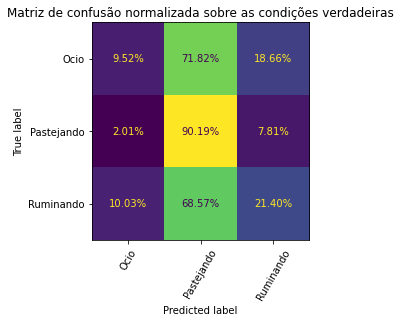

Acurácia treino:  75.59806755786656
              precision    recall  f1-score   support

        Ocio      0.746     0.479     0.583     81676
  Pastejando      0.763     0.911     0.830    185883
   Ruminando      0.745     0.690     0.716     93228

    accuracy                          0.756    360787
   macro avg      0.751     0.693     0.710    360787
weighted avg      0.754     0.756     0.745    360787

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=0)
Acurácia teste:  59.27797599477195
              precision    recall  f1-score   support

        Ocio      0.290     0.144     0.193     41581
  Pastejando      0.660     0.883     0.755    146629
   Ruminando      0.359     0.181     0.241     58153

    accuracy                          0.593    246363
   macro avg      0.436     0.403     0.396    246363
weighted avg      0.526 

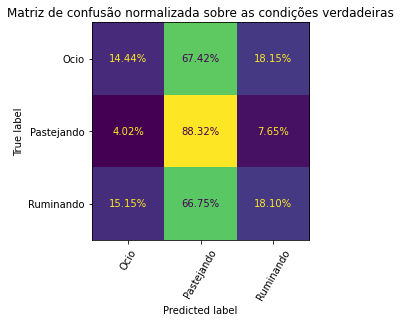

Acurácia treino:  88.52702564116778
              precision    recall  f1-score   support

        Ocio      0.924     0.757     0.832     81676
  Pastejando      0.870     0.963     0.915    185883
   Ruminando      0.891     0.842     0.866     93228

    accuracy                          0.885    360787
   macro avg      0.895     0.854     0.871    360787
weighted avg      0.888     0.885     0.883    360787

KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=37, p=1,
                     weights='distance')
Acurácia teste:  59.016979010646885
              precision    recall  f1-score   support

        Ocio      0.293     0.147     0.196     41581
  Pastejando      0.668     0.858     0.751    146629
   Ruminando      0.363     0.231     0.282     58153

    accuracy                          0.590    246363
   macro avg      0.441     0.412     0.410    246363
weighted avg      0.533     0.590     0.547    246363



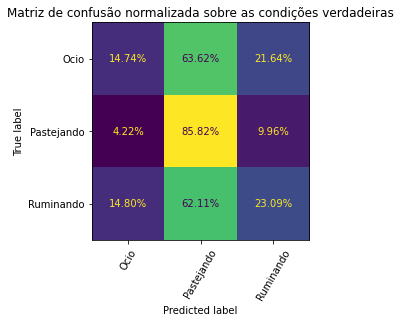

Acurácia treino:  99.98586423568476
              precision    recall  f1-score   support

        Ocio      1.000     1.000     1.000     81676
  Pastejando      1.000     1.000     1.000    185883
   Ruminando      1.000     1.000     1.000     93228

    accuracy                          1.000    360787
   macro avg      1.000     1.000     1.000    360787
weighted avg      1.000     1.000     1.000    360787

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 30, 30, 20),
              learning_rate='adaptive', random_state=0)
Acurácia teste:  59.357127490735216
              precision    recall  f1-score   support

        Ocio      0.301     0.106     0.157     41581
  Pastejando      0.643     0.888     0.746    146629
   Ruminando      0.398     0.199     0.265     58153

    accuracy                          0.594    246363
   macro avg      0.447     0.398     0.389    246363
weighted avg      0.527     0.594     0.533    246363



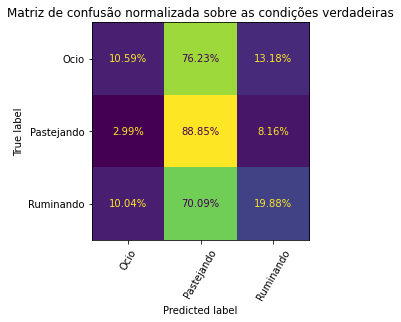

Acurácia treino:  69.10808870607865
              precision    recall  f1-score   support

        Ocio      0.584     0.393     0.470     81676
  Pastejando      0.723     0.870     0.790    185883
   Ruminando      0.677     0.595     0.633     93228

    accuracy                          0.691    360787
   macro avg      0.661     0.619     0.631    360787
weighted avg      0.679     0.691     0.677    360787

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5370264280766771,
              enable_categorical=False, gamma=0.0, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=16,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=0, reg_alpha=None, reg_lambda=None,
              scale_po

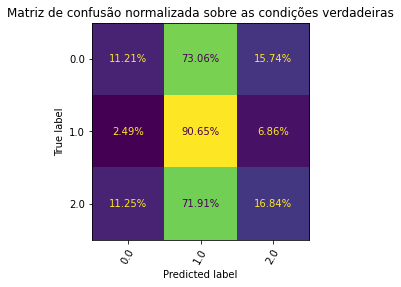

Acurácia treino:  90.71917779742618
              precision    recall  f1-score   support

         0.0      0.948     0.789     0.861     81676
         1.0      0.896     0.971     0.932    185883
         2.0      0.901     0.885     0.892     93228

    accuracy                          0.907    360787
   macro avg      0.915     0.881     0.895    360787
weighted avg      0.909     0.907     0.906    360787



In [130]:
treinar_e_reportar(models, X_train, y_train, X_test, y_test)   

##### Com GLM 

In [100]:
df_test = df[df.Season_fall == 1]

In [101]:
df_train = df[df.Season_fall == 0]

         Current function value: 0.976426
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  58.235205773594245
              precision    recall  f1-score   support

           0      0.234     0.114     0.153     41581
           1      0.640     0.852     0.731    146629
           2      0.446     0.237     0.310     58153

   micro avg      0.582     0.582     0.582    246363
   macro avg      0.440     0.401     0.398    246363
weighted avg      0.526     0.582     0.534    246363
 samples avg      0.582     0.582     0.582    246363



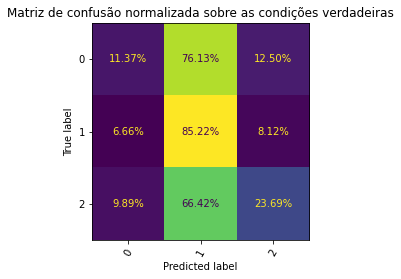

In [104]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')

#### Leave Height Out 10 cm

In [86]:
df_test = df[df['Altura esperada'] == 10.0]

In [87]:
df_train = df[df['Altura esperada'] != 10.0]

In [88]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

LGBMClassifier(colsample_bytree=0.662, min_child_samples=1, num_leaves=512,
               random_state=0, subsample_freq=1)
Acurácia teste:  54.15330827016921
              precision    recall  f1-score   support

        Ocio      0.362     0.072     0.120     40651
  Pastejando      0.598     0.871     0.709     83076
   Ruminando      0.260     0.203     0.228     24432

    accuracy                          0.542    148159
   macro avg      0.407     0.382     0.352    148159
weighted avg      0.478     0.542     0.468    148159



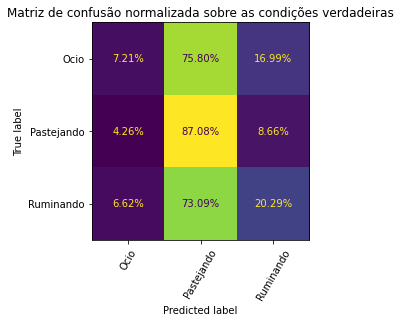

Acurácia treino:  78.79500905246508
              precision    recall  f1-score   support

        Ocio      0.744     0.435     0.549     82606
  Pastejando      0.810     0.919     0.861    249436
   Ruminando      0.757     0.761     0.759    126949

    accuracy                          0.788    458991
   macro avg      0.770     0.705     0.723    458991
weighted avg      0.783     0.788     0.776    458991

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=0)
Acurácia teste:  53.80435883071565
              precision    recall  f1-score   support

        Ocio      0.355     0.080     0.131     40651
  Pastejando      0.595     0.866     0.705     83076
   Ruminando      0.250     0.185     0.213     24432

    accuracy                          0.538    148159
   macro avg      0.400     0.377     0.350    148159
weighted avg      0.472 

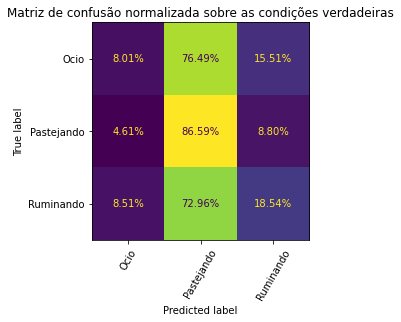

Acurácia treino:  89.41896464200823
              precision    recall  f1-score   support

        Ocio      0.927     0.704     0.800     82606
  Pastejando      0.888     0.965     0.925    249436
   Ruminando      0.892     0.879     0.885    126949

    accuracy                          0.894    458991
   macro avg      0.902     0.849     0.870    458991
weighted avg      0.896     0.894     0.891    458991

KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=37, p=1,
                     weights='distance')
Acurácia teste:  53.04908915421945
              precision    recall  f1-score   support

        Ocio      0.335     0.088     0.139     40651
  Pastejando      0.599     0.840     0.700     83076
   Ruminando      0.248     0.213     0.229     24432

    accuracy                          0.530    148159
   macro avg      0.394     0.380     0.356    148159
weighted avg      0.469     0.530     0.468    148159



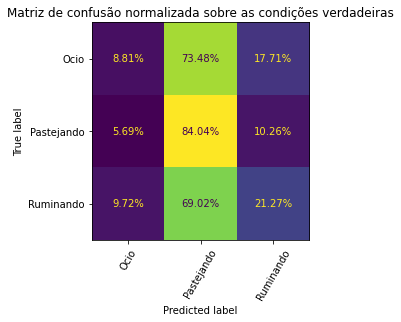

Acurácia treino:  99.98714571745415
              precision    recall  f1-score   support

        Ocio      0.999     1.000     1.000     82606
  Pastejando      1.000     1.000     1.000    249436
   Ruminando      1.000     1.000     1.000    126949

    accuracy                          1.000    458991
   macro avg      1.000     1.000     1.000    458991
weighted avg      1.000     1.000     1.000    458991

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 30, 30, 20),
              learning_rate='adaptive', random_state=0)
Acurácia teste:  53.43786067670543
              precision    recall  f1-score   support

        Ocio      0.341     0.065     0.109     40651
  Pastejando      0.592     0.861     0.701     83076
   Ruminando      0.256     0.206     0.228     24432

    accuracy                          0.534    148159
   macro avg      0.396     0.377     0.346    148159
weighted avg      0.468     0.534     0.461    148159



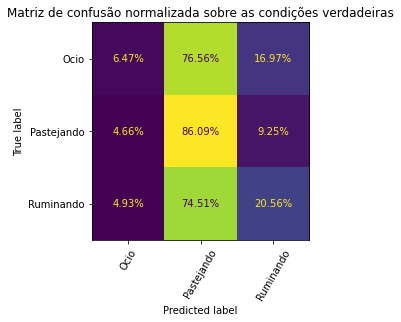

Acurácia treino:  73.59577856646426
              precision    recall  f1-score   support

        Ocio      0.590     0.324     0.419     82606
  Pastejando      0.780     0.887     0.830    249436
   Ruminando      0.691     0.706     0.698    126949

    accuracy                          0.736    458991
   macro avg      0.687     0.639     0.649    458991
weighted avg      0.721     0.736     0.720    458991

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5370264280766771,
              enable_categorical=False, gamma=0.0, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=16,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=0, reg_alpha=None, reg_lambda=None,
              scale_po

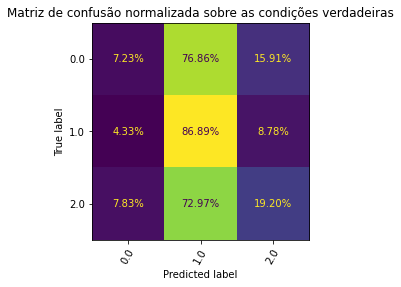

Acurácia treino:  91.01725306160688
              precision    recall  f1-score   support

         0.0      0.933     0.728     0.818     82606
         1.0      0.913     0.967     0.940    249436
         2.0      0.892     0.917     0.904    126949

    accuracy                          0.910    458991
   macro avg      0.913     0.871     0.887    458991
weighted avg      0.911     0.910     0.908    458991



In [89]:
treinar_e_reportar(models, X_train, y_train, X_test, y_test) 

##### Com GLM 

In [131]:
df_test = df[df['Altura esperada'] == 10.0]

In [132]:
df_train = df[df['Altura esperada'] != 10.0]

         Current function value: 0.928654
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  46.63570893432056
              precision    recall  f1-score   support

           0      0.310     0.048     0.082     40651
           1      0.565     0.785     0.657     83076
           2      0.074     0.080     0.077     24432

   micro avg      0.466     0.466     0.466    148159
   macro avg      0.316     0.304     0.272    148159
weighted avg      0.414     0.466     0.404    148159
 samples avg      0.466     0.466     0.466    148159



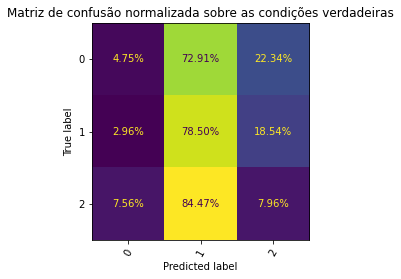

In [133]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')

#### Leave Animals Out

In [362]:
df.Animal.value_counts()

95     119449
81     113724
84     110268
93      98043
21      58809
22      58734
90      47549
105       574
Name: Animal, dtype: int64

In [363]:
df_test = df.loc[df['Animal'].isin([84, 93])]

In [364]:
df_test.Animal.value_counts()

84    110268
93     98043
Name: Animal, dtype: int64

In [365]:
df_train = df.loc[~df['Animal'].isin([84, 93])]

In [366]:
df_train.Animal.value_counts()

95     119449
81     113724
21      58809
22      58734
90      47549
105       574
Name: Animal, dtype: int64

In [367]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

LGBMClassifier(colsample_bytree=0.662, min_child_samples=1, num_leaves=512,
               random_state=0, subsample_freq=1)
Acurácia teste:  52.6501240933028
              precision    recall  f1-score   support

        Ocio      0.278     0.146     0.191     37531
  Pastejando      0.589     0.842     0.693    114197
   Ruminando      0.316     0.142     0.196     56583

    accuracy                          0.527    208311
   macro avg      0.394     0.377     0.360    208311
weighted avg      0.459     0.527     0.468    208311



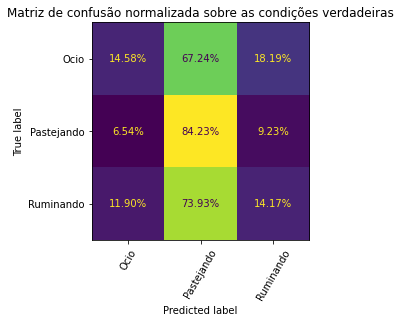

Acurácia treino:  79.08780234631017
              precision    recall  f1-score   support

        Ocio      0.768     0.512     0.614     85726
  Pastejando      0.807     0.927     0.863    218315
   Ruminando      0.762     0.730     0.746     94798

    accuracy                          0.791    398839
   macro avg      0.779     0.723     0.741    398839
weighted avg      0.788     0.791     0.781    398839

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=0)
Acurácia teste:  52.07358228802128
              precision    recall  f1-score   support

        Ocio      0.268     0.145     0.188     37531
  Pastejando      0.584     0.835     0.687    114197
   Ruminando      0.310     0.137     0.190     56583

    accuracy                          0.521    208311
   macro avg      0.387     0.372     0.355    208311
weighted avg      0.453 

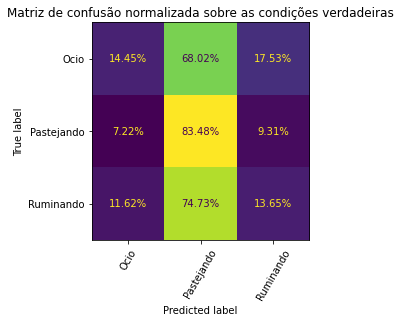

Acurácia treino:  89.75250665055323
              precision    recall  f1-score   support

        Ocio      0.926     0.763     0.837     85726
  Pastejando      0.890     0.968     0.928    218315
   Ruminando      0.894     0.857     0.875     94798

    accuracy                          0.898    398839
   macro avg      0.904     0.862     0.880    398839
weighted avg      0.899     0.898     0.896    398839

KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=37, p=1,
                     weights='distance')
Acurácia teste:  51.37222710274541
              precision    recall  f1-score   support

        Ocio      0.249     0.171     0.202     37531
  Pastejando      0.597     0.805     0.685    114197
   Ruminando      0.305     0.153     0.204     56583

    accuracy                          0.514    208311
   macro avg      0.383     0.376     0.364    208311
weighted avg      0.455     0.514     0.468    208311



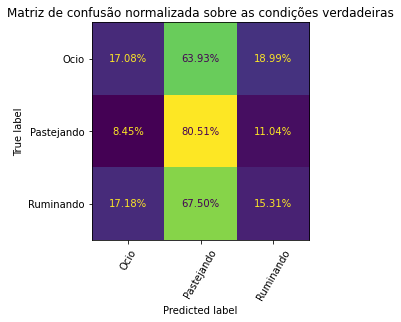

Acurácia treino:  99.9882157963489
              precision    recall  f1-score   support

        Ocio      1.000     1.000     1.000     85726
  Pastejando      1.000     1.000     1.000    218315
   Ruminando      1.000     1.000     1.000     94798

    accuracy                          1.000    398839
   macro avg      1.000     1.000     1.000    398839
weighted avg      1.000     1.000     1.000    398839

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 30, 30, 20),
              learning_rate='adaptive', random_state=0)
Acurácia teste:  52.24448060832121
              precision    recall  f1-score   support

        Ocio      0.299     0.148     0.198     37531
  Pastejando      0.590     0.829     0.689    114197
   Ruminando      0.295     0.151     0.200     56583

    accuracy                          0.522    208311
   macro avg      0.394     0.376     0.362    208311
weighted avg      0.457     0.522     0.468    208311



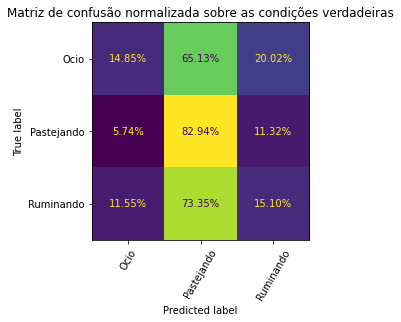

Acurácia treino:  73.00138652438703
              precision    recall  f1-score   support

        Ocio      0.629     0.390     0.482     85726
  Pastejando      0.770     0.893     0.827    218315
   Ruminando      0.678     0.661     0.669     94798

    accuracy                          0.730    398839
   macro avg      0.692     0.648     0.659    398839
weighted avg      0.718     0.730     0.715    398839

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5370264280766771,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=16,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=

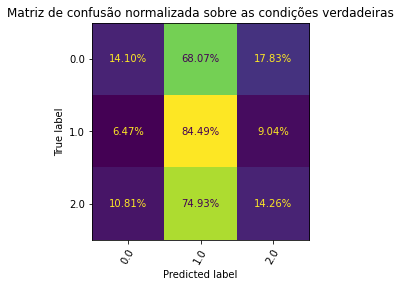

Acurácia treino:  92.68501826551567
              precision    recall  f1-score   support

         0.0      0.952     0.807     0.873     85726
         1.0      0.926     0.976     0.950    218315
         2.0      0.911     0.923     0.917     94798

    accuracy                          0.927    398839
   macro avg      0.929     0.902     0.913    398839
weighted avg      0.928     0.927     0.926    398839



In [368]:
treinar_e_reportar(models, X_train, y_train, X_test, y_test)

##### Com GLM 

In [134]:
df_test = df.loc[df['Animal'].isin([84, 93])]

In [135]:
df_train = df.loc[~df['Animal'].isin([84, 93])]

         Current function value: 0.941192
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  54.80459505258963
              precision    recall  f1-score   support

           0      0.498     0.105     0.173     37531
           1      0.563     0.951     0.707    114197
           2      0.217     0.028     0.050     56583

   micro avg      0.548     0.548     0.548    208311
   macro avg      0.426     0.361     0.310    208311
weighted avg      0.457     0.548     0.432    208311
 samples avg      0.548     0.548     0.548    208311



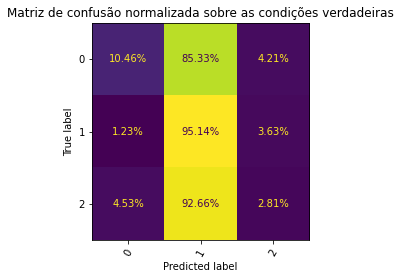

In [136]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')